<a href="https://colab.research.google.com/github/yastiaisyah/DataSynthesis/blob/main/11_05_24_GAN_Epoch100.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import cv2
import numpy
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as tt
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.utils import make_grid,save_image
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
DIR = '/content/drive/MyDrive/dataset/real'
os.listdir(DIR)

['human']

In [4]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
train_ds = ImageFolder(DIR,transform = tt.Compose([
    tt.Resize(image_size),
    tt.CenterCrop(image_size),
    tt.RandomHorizontalFlip(p=0.5),
    tt.ToTensor(),
    tt.Normalize(*stats)
]))
train_dl = DataLoader(train_ds,batch_size,shuffle = True,num_workers = 3, pin_memory = True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [5]:
def denorm(img_tensor):
    return img_tensor*stats[1][0] + stats[0][0]

In [6]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


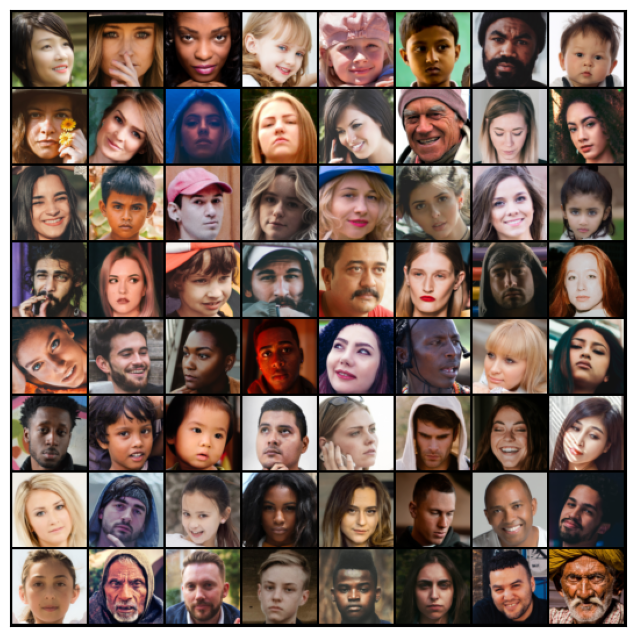

In [7]:
show_batch(train_dl)

In [8]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data,device):
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device, non_blocking = True)

class DeviceDataLoader():
    def __init__(self,dl,device):
        self.dl = dl
        self.device = device
    def __iter__(self):
        for b in self.dl:
            yield to_device(b,device)
    def __len__(self):
        return len(self.dl)

In [9]:
device = get_default_device()
device

device(type='cpu')

In [10]:
train_dl = DeviceDataLoader(train_dl,device)

In [11]:
discriminator = nn.Sequential(

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),

    nn.Flatten(),
    nn.Sigmoid())

In [12]:
discriminator = to_device(discriminator,device)

In [13]:
latent_size = 128
generator = nn.Sequential(

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
)

torch.Size([128, 3, 64, 64])


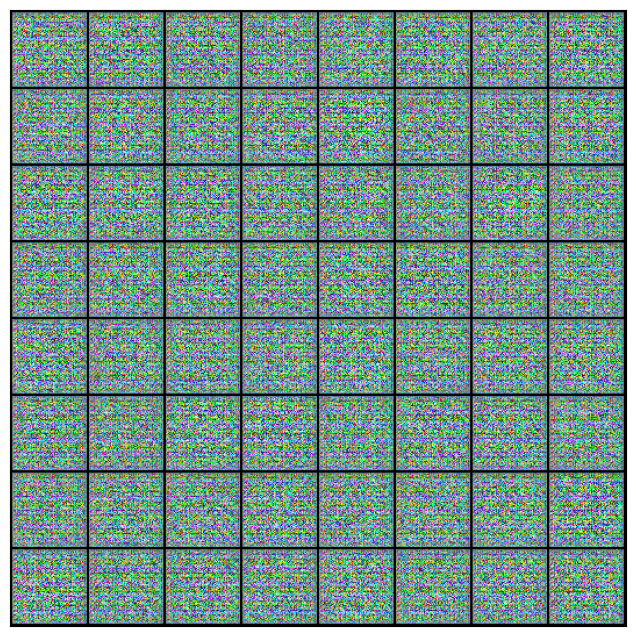

In [14]:
xb = torch.randn(batch_size,latent_size,1,1)
fake_image = generator(xb)
print(fake_image.shape)
show_images(fake_image)

In [15]:
generator = to_device(generator, device)

In [16]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [17]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)

    # Update generator weights
    loss.backward()
    opt_g.step()

    return loss.item()

In [18]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [19]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    print(fake_images.size())
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [20]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)
fixed_latent.shape

torch.Size([64, 128, 1, 1])

torch.Size([64, 3, 64, 64])
Saving generated-images-0000.png


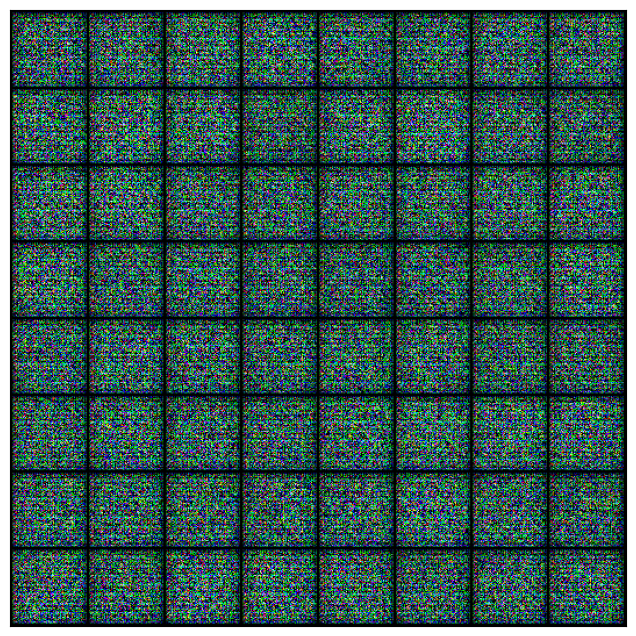

In [21]:
save_samples(0, fixed_latent)

In [22]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()

    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)

        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))

        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)

    return losses_g, losses_d, real_scores, fake_scores

In [23]:
lr = 0.0002
epochs = 100

In [24]:
history = fit(epochs, lr)

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [1/100], loss_g: 5.9493, loss_d: 0.3059, real_score: 0.8452, fake_score: 0.0781
torch.Size([64, 3, 64, 64])
Saving generated-images-0001.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [2/100], loss_g: 9.1547, loss_d: 0.2143, real_score: 0.8386, fake_score: 0.0004
torch.Size([64, 3, 64, 64])
Saving generated-images-0002.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [3/100], loss_g: 11.2971, loss_d: 0.3114, real_score: 0.8851, fake_score: 0.0000
torch.Size([64, 3, 64, 64])
Saving generated-images-0003.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [4/100], loss_g: 6.7951, loss_d: 0.1101, real_score: 0.9247, fake_score: 0.0011
torch.Size([64, 3, 64, 64])
Saving generated-images-0004.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [5/100], loss_g: 7.6849, loss_d: 0.1841, real_score: 0.9461, fake_score: 0.1107
torch.Size([64, 3, 64, 64])
Saving generated-images-0005.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [6/100], loss_g: 5.7540, loss_d: 0.2882, real_score: 0.8881, fake_score: 0.0739
torch.Size([64, 3, 64, 64])
Saving generated-images-0006.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [7/100], loss_g: 12.7275, loss_d: 0.0744, real_score: 0.9395, fake_score: 0.0001
torch.Size([64, 3, 64, 64])
Saving generated-images-0007.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [8/100], loss_g: 11.8300, loss_d: 0.0538, real_score: 0.9515, fake_score: 0.0000
torch.Size([64, 3, 64, 64])
Saving generated-images-0008.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [9/100], loss_g: 15.7223, loss_d: 0.4309, real_score: 0.7194, fake_score: 0.0000
torch.Size([64, 3, 64, 64])
Saving generated-images-0009.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [10/100], loss_g: 5.1852, loss_d: 0.1762, real_score: 0.8733, fake_score: 0.0199
torch.Size([64, 3, 64, 64])
Saving generated-images-0010.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [11/100], loss_g: 7.1653, loss_d: 0.1262, real_score: 0.9099, fake_score: 0.0140
torch.Size([64, 3, 64, 64])
Saving generated-images-0011.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [12/100], loss_g: 8.1402, loss_d: 0.0887, real_score: 0.9253, fake_score: 0.0054
torch.Size([64, 3, 64, 64])
Saving generated-images-0012.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [13/100], loss_g: 4.7826, loss_d: 0.1559, real_score: 0.9366, fake_score: 0.0793
torch.Size([64, 3, 64, 64])
Saving generated-images-0013.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [14/100], loss_g: 6.1002, loss_d: 0.6226, real_score: 0.9188, fake_score: 0.2940
torch.Size([64, 3, 64, 64])
Saving generated-images-0014.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [15/100], loss_g: 2.5366, loss_d: 0.5008, real_score: 0.7493, fake_score: 0.1192
torch.Size([64, 3, 64, 64])
Saving generated-images-0015.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [16/100], loss_g: 2.6879, loss_d: 0.5316, real_score: 0.8060, fake_score: 0.2384
torch.Size([64, 3, 64, 64])
Saving generated-images-0016.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [17/100], loss_g: 1.4366, loss_d: 0.6544, real_score: 0.6659, fake_score: 0.1187
torch.Size([64, 3, 64, 64])
Saving generated-images-0017.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [18/100], loss_g: 3.1961, loss_d: 0.3256, real_score: 0.8517, fake_score: 0.1353
torch.Size([64, 3, 64, 64])
Saving generated-images-0018.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [19/100], loss_g: 2.4790, loss_d: 0.5850, real_score: 0.9111, fake_score: 0.3590
torch.Size([64, 3, 64, 64])
Saving generated-images-0019.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [20/100], loss_g: 2.7069, loss_d: 0.3939, real_score: 0.7792, fake_score: 0.0991
torch.Size([64, 3, 64, 64])
Saving generated-images-0020.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [21/100], loss_g: 3.5821, loss_d: 0.7856, real_score: 0.5401, fake_score: 0.0273
torch.Size([64, 3, 64, 64])
Saving generated-images-0021.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [22/100], loss_g: 3.1630, loss_d: 0.7639, real_score: 0.5542, fake_score: 0.0266
torch.Size([64, 3, 64, 64])
Saving generated-images-0022.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [23/100], loss_g: 5.2243, loss_d: 0.5210, real_score: 0.9449, fake_score: 0.3362
torch.Size([64, 3, 64, 64])
Saving generated-images-0023.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [24/100], loss_g: 4.3775, loss_d: 0.4455, real_score: 0.8617, fake_score: 0.2285
torch.Size([64, 3, 64, 64])
Saving generated-images-0024.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [25/100], loss_g: 5.5112, loss_d: 0.3345, real_score: 0.9071, fake_score: 0.1805
torch.Size([64, 3, 64, 64])
Saving generated-images-0025.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [26/100], loss_g: 2.9205, loss_d: 0.3089, real_score: 0.8995, fake_score: 0.1563
torch.Size([64, 3, 64, 64])
Saving generated-images-0026.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [27/100], loss_g: 3.5616, loss_d: 0.4131, real_score: 0.7745, fake_score: 0.0953
torch.Size([64, 3, 64, 64])
Saving generated-images-0027.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [28/100], loss_g: 3.7171, loss_d: 0.3328, real_score: 0.7893, fake_score: 0.0617
torch.Size([64, 3, 64, 64])
Saving generated-images-0028.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [29/100], loss_g: 3.0248, loss_d: 0.3287, real_score: 0.7680, fake_score: 0.0300
torch.Size([64, 3, 64, 64])
Saving generated-images-0029.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [30/100], loss_g: 2.3597, loss_d: 1.5842, real_score: 0.2875, fake_score: 0.0055
torch.Size([64, 3, 64, 64])
Saving generated-images-0030.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [31/100], loss_g: 3.4675, loss_d: 0.4150, real_score: 0.8045, fake_score: 0.1269
torch.Size([64, 3, 64, 64])
Saving generated-images-0031.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [32/100], loss_g: 3.9704, loss_d: 0.3625, real_score: 0.8110, fake_score: 0.0949
torch.Size([64, 3, 64, 64])
Saving generated-images-0032.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [33/100], loss_g: 4.0043, loss_d: 0.3378, real_score: 0.8450, fake_score: 0.1249
torch.Size([64, 3, 64, 64])
Saving generated-images-0033.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [34/100], loss_g: 4.0431, loss_d: 0.4011, real_score: 0.8177, fake_score: 0.1484
torch.Size([64, 3, 64, 64])
Saving generated-images-0034.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [35/100], loss_g: 3.9948, loss_d: 2.2934, real_score: 0.1864, fake_score: 0.0016
torch.Size([64, 3, 64, 64])
Saving generated-images-0035.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [36/100], loss_g: 4.6438, loss_d: 0.5826, real_score: 0.8664, fake_score: 0.3105
torch.Size([64, 3, 64, 64])
Saving generated-images-0036.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [37/100], loss_g: 7.2168, loss_d: 0.7438, real_score: 0.9303, fake_score: 0.4403
torch.Size([64, 3, 64, 64])
Saving generated-images-0037.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [38/100], loss_g: 3.3016, loss_d: 0.3289, real_score: 0.8625, fake_score: 0.1414
torch.Size([64, 3, 64, 64])
Saving generated-images-0038.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [39/100], loss_g: 4.7109, loss_d: 0.7875, real_score: 0.9038, fake_score: 0.4142
torch.Size([64, 3, 64, 64])
Saving generated-images-0039.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [40/100], loss_g: 4.4279, loss_d: 0.4327, real_score: 0.7593, fake_score: 0.0471
torch.Size([64, 3, 64, 64])
Saving generated-images-0040.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [41/100], loss_g: 4.1262, loss_d: 0.4291, real_score: 0.7783, fake_score: 0.0943
torch.Size([64, 3, 64, 64])
Saving generated-images-0041.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [42/100], loss_g: 2.5794, loss_d: 0.5597, real_score: 0.7649, fake_score: 0.1985
torch.Size([64, 3, 64, 64])
Saving generated-images-0042.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [43/100], loss_g: 3.2622, loss_d: 0.5752, real_score: 0.7295, fake_score: 0.1605
torch.Size([64, 3, 64, 64])
Saving generated-images-0043.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [44/100], loss_g: 4.2762, loss_d: 0.6869, real_score: 0.7583, fake_score: 0.2767
torch.Size([64, 3, 64, 64])
Saving generated-images-0044.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [45/100], loss_g: 4.6638, loss_d: 0.4898, real_score: 0.9148, fake_score: 0.2955
torch.Size([64, 3, 64, 64])
Saving generated-images-0045.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [46/100], loss_g: 3.5713, loss_d: 0.4782, real_score: 0.7792, fake_score: 0.1643
torch.Size([64, 3, 64, 64])
Saving generated-images-0046.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [47/100], loss_g: 3.2540, loss_d: 0.3869, real_score: 0.8783, fake_score: 0.1915
torch.Size([64, 3, 64, 64])
Saving generated-images-0047.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [48/100], loss_g: 3.5024, loss_d: 0.3759, real_score: 0.7985, fake_score: 0.1014
torch.Size([64, 3, 64, 64])
Saving generated-images-0048.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [49/100], loss_g: 2.8264, loss_d: 0.4312, real_score: 0.7527, fake_score: 0.0843
torch.Size([64, 3, 64, 64])
Saving generated-images-0049.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [50/100], loss_g: 6.4826, loss_d: 0.9508, real_score: 0.9473, fake_score: 0.5130
torch.Size([64, 3, 64, 64])
Saving generated-images-0050.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [51/100], loss_g: 2.7668, loss_d: 0.4804, real_score: 0.8027, fake_score: 0.1905
torch.Size([64, 3, 64, 64])
Saving generated-images-0051.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [52/100], loss_g: 2.5060, loss_d: 0.6217, real_score: 0.6571, fake_score: 0.1079
torch.Size([64, 3, 64, 64])
Saving generated-images-0052.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [53/100], loss_g: 2.8554, loss_d: 0.7601, real_score: 0.5931, fake_score: 0.0404
torch.Size([64, 3, 64, 64])
Saving generated-images-0053.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [54/100], loss_g: 2.8454, loss_d: 0.4910, real_score: 0.7029, fake_score: 0.0664
torch.Size([64, 3, 64, 64])
Saving generated-images-0054.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [55/100], loss_g: 3.1421, loss_d: 0.4725, real_score: 0.8034, fake_score: 0.1885
torch.Size([64, 3, 64, 64])
Saving generated-images-0055.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [56/100], loss_g: 4.3597, loss_d: 0.2629, real_score: 0.8506, fake_score: 0.0661
torch.Size([64, 3, 64, 64])
Saving generated-images-0056.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [57/100], loss_g: 4.9478, loss_d: 0.4541, real_score: 0.8430, fake_score: 0.2107
torch.Size([64, 3, 64, 64])
Saving generated-images-0057.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [58/100], loss_g: 4.3602, loss_d: 0.7179, real_score: 0.8064, fake_score: 0.3440
torch.Size([64, 3, 64, 64])
Saving generated-images-0058.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [59/100], loss_g: 3.9161, loss_d: 0.4625, real_score: 0.8189, fake_score: 0.1873
torch.Size([64, 3, 64, 64])
Saving generated-images-0059.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [60/100], loss_g: 2.5316, loss_d: 0.4938, real_score: 0.7078, fake_score: 0.0837
torch.Size([64, 3, 64, 64])
Saving generated-images-0060.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [61/100], loss_g: 2.9065, loss_d: 0.4782, real_score: 0.7258, fake_score: 0.0553
torch.Size([64, 3, 64, 64])
Saving generated-images-0061.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [62/100], loss_g: 2.5821, loss_d: 0.7950, real_score: 0.5326, fake_score: 0.0318
torch.Size([64, 3, 64, 64])
Saving generated-images-0062.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [63/100], loss_g: 3.0908, loss_d: 0.4171, real_score: 0.7441, fake_score: 0.0743
torch.Size([64, 3, 64, 64])
Saving generated-images-0063.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [64/100], loss_g: 3.3471, loss_d: 0.6874, real_score: 0.7243, fake_score: 0.2389
torch.Size([64, 3, 64, 64])
Saving generated-images-0064.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [65/100], loss_g: 2.1659, loss_d: 0.6603, real_score: 0.6464, fake_score: 0.1036
torch.Size([64, 3, 64, 64])
Saving generated-images-0065.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [66/100], loss_g: 3.9591, loss_d: 0.4731, real_score: 0.8280, fake_score: 0.2075
torch.Size([64, 3, 64, 64])
Saving generated-images-0066.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [67/100], loss_g: 4.0461, loss_d: 0.3462, real_score: 0.8879, fake_score: 0.1878
torch.Size([64, 3, 64, 64])
Saving generated-images-0067.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [68/100], loss_g: 3.1923, loss_d: 1.2204, real_score: 0.3989, fake_score: 0.0043
torch.Size([64, 3, 64, 64])
Saving generated-images-0068.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [69/100], loss_g: 5.4790, loss_d: 0.7097, real_score: 0.8943, fake_score: 0.4100
torch.Size([64, 3, 64, 64])
Saving generated-images-0069.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [70/100], loss_g: 5.3051, loss_d: 0.6750, real_score: 0.8754, fake_score: 0.3601
torch.Size([64, 3, 64, 64])
Saving generated-images-0070.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [71/100], loss_g: 2.2167, loss_d: 0.3601, real_score: 0.8700, fake_score: 0.1725
torch.Size([64, 3, 64, 64])
Saving generated-images-0071.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [72/100], loss_g: 3.8010, loss_d: 0.4646, real_score: 0.8636, fake_score: 0.2434
torch.Size([64, 3, 64, 64])
Saving generated-images-0072.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [73/100], loss_g: 5.5374, loss_d: 0.6283, real_score: 0.9250, fake_score: 0.3835
torch.Size([64, 3, 64, 64])
Saving generated-images-0073.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [74/100], loss_g: 5.1013, loss_d: 0.5817, real_score: 0.8391, fake_score: 0.2943
torch.Size([64, 3, 64, 64])
Saving generated-images-0074.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [75/100], loss_g: 4.0591, loss_d: 0.6549, real_score: 0.8553, fake_score: 0.3419
torch.Size([64, 3, 64, 64])
Saving generated-images-0075.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [76/100], loss_g: 2.6820, loss_d: 0.5435, real_score: 0.7260, fake_score: 0.1571
torch.Size([64, 3, 64, 64])
Saving generated-images-0076.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [77/100], loss_g: 2.2963, loss_d: 0.6643, real_score: 0.5838, fake_score: 0.0245
torch.Size([64, 3, 64, 64])
Saving generated-images-0077.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [78/100], loss_g: 4.3856, loss_d: 0.4818, real_score: 0.8680, fake_score: 0.2539
torch.Size([64, 3, 64, 64])
Saving generated-images-0078.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [79/100], loss_g: 2.7396, loss_d: 0.7238, real_score: 0.5587, fake_score: 0.0275
torch.Size([64, 3, 64, 64])
Saving generated-images-0079.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [80/100], loss_g: 3.3095, loss_d: 1.3926, real_score: 0.3263, fake_score: 0.0051
torch.Size([64, 3, 64, 64])
Saving generated-images-0080.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [81/100], loss_g: 3.3151, loss_d: 0.5192, real_score: 0.7805, fake_score: 0.1942
torch.Size([64, 3, 64, 64])
Saving generated-images-0081.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [82/100], loss_g: 4.2125, loss_d: 0.6354, real_score: 0.7856, fake_score: 0.2832
torch.Size([64, 3, 64, 64])
Saving generated-images-0082.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [83/100], loss_g: 2.4674, loss_d: 0.8651, real_score: 0.4984, fake_score: 0.0105
torch.Size([64, 3, 64, 64])
Saving generated-images-0083.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [84/100], loss_g: 6.4795, loss_d: 0.8813, real_score: 0.9675, fake_score: 0.5206
torch.Size([64, 3, 64, 64])
Saving generated-images-0084.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [85/100], loss_g: 5.2458, loss_d: 0.5475, real_score: 0.9234, fake_score: 0.3164
torch.Size([64, 3, 64, 64])
Saving generated-images-0085.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [86/100], loss_g: 1.2863, loss_d: 0.7075, real_score: 0.5850, fake_score: 0.0538
torch.Size([64, 3, 64, 64])
Saving generated-images-0086.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [87/100], loss_g: 3.2754, loss_d: 0.4650, real_score: 0.8310, fake_score: 0.2070
torch.Size([64, 3, 64, 64])
Saving generated-images-0087.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [88/100], loss_g: 2.7797, loss_d: 0.6130, real_score: 0.6792, fake_score: 0.1142
torch.Size([64, 3, 64, 64])
Saving generated-images-0088.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [89/100], loss_g: 3.2448, loss_d: 0.3535, real_score: 0.7983, fake_score: 0.1041
torch.Size([64, 3, 64, 64])
Saving generated-images-0089.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [90/100], loss_g: 2.6008, loss_d: 0.5600, real_score: 0.6815, fake_score: 0.1221
torch.Size([64, 3, 64, 64])
Saving generated-images-0090.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [91/100], loss_g: 2.7213, loss_d: 0.5007, real_score: 0.7225, fake_score: 0.1256
torch.Size([64, 3, 64, 64])
Saving generated-images-0091.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [92/100], loss_g: 4.2519, loss_d: 0.4231, real_score: 0.8814, fake_score: 0.2300
torch.Size([64, 3, 64, 64])
Saving generated-images-0092.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [93/100], loss_g: 3.0469, loss_d: 0.4623, real_score: 0.7560, fake_score: 0.1109
torch.Size([64, 3, 64, 64])
Saving generated-images-0093.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [94/100], loss_g: 1.4351, loss_d: 0.5839, real_score: 0.6240, fake_score: 0.0320
torch.Size([64, 3, 64, 64])
Saving generated-images-0094.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [95/100], loss_g: 1.6017, loss_d: 0.9047, real_score: 0.5051, fake_score: 0.0563
torch.Size([64, 3, 64, 64])
Saving generated-images-0095.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [96/100], loss_g: 2.7758, loss_d: 0.5505, real_score: 0.6544, fake_score: 0.0714
torch.Size([64, 3, 64, 64])
Saving generated-images-0096.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [97/100], loss_g: 3.4803, loss_d: 0.3827, real_score: 0.7800, fake_score: 0.0900
torch.Size([64, 3, 64, 64])
Saving generated-images-0097.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [98/100], loss_g: 3.9330, loss_d: 0.4323, real_score: 0.8588, fake_score: 0.2120
torch.Size([64, 3, 64, 64])
Saving generated-images-0098.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [99/100], loss_g: 1.4435, loss_d: 1.0899, real_score: 0.4437, fake_score: 0.0142
torch.Size([64, 3, 64, 64])
Saving generated-images-0099.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [100/100], loss_g: 4.3081, loss_d: 0.4348, real_score: 0.8889, fake_score: 0.2390
torch.Size([64, 3, 64, 64])
Saving generated-images-0100.png


In [25]:
losses_g, losses_d, real_scores, fake_scores = history

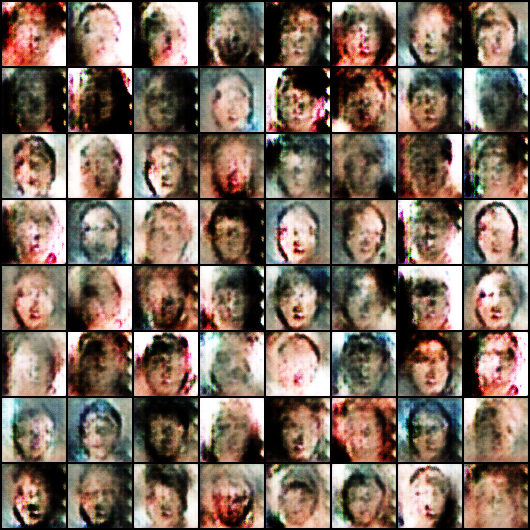

In [26]:
from IPython.display import Image
Image('./generated/generated-images-0060.png')

In [27]:
vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

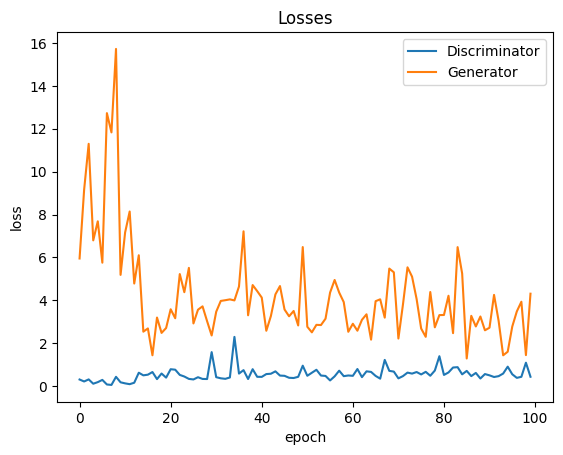

In [28]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

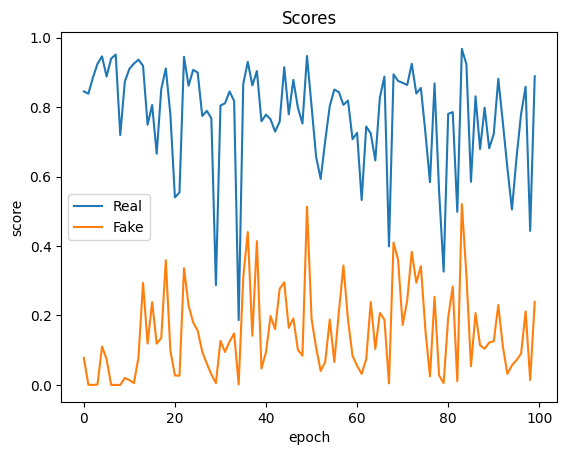

In [29]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');